In [1]:
from __future__ import division, print_function

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots, imshow, plot, axis, axvline, title
plt.style.use('bmh')

from mriqa.phantoms import phantom_mask_2d, find_phantom, TO4, TO4B
from mriqa.dcmio import fetch_series, pix_spacing_yx, approx_slice_orientation, approx_phase_orientation, seq_name
from mriqa.tools import mean_im, diff_im, snr_im, snr, show_mosaic, peakdet

In [2]:
from scipy.ndimage import zoom as ndizoom
from scipy.ndimage.interpolation import rotate as ndirotate
from scipy.signal import correlate

def bars_roi(image, pix_dims, rect, centre):
    '''Get a region of interest for a bars pattern. The bars roi rectangle is specified as (x, y, dx, dy) in mm.
       The region of interest is shifted according to the specified phantom centre (in mm)
    '''
    centre_x, centre_y = centre
    (x, y), (dx, dy) = np.array(rect) / pix_dims
    x += (centre_x - image.shape[1])
    y += (centre_y - image.shape[0])
    return image[y:y+dy, x:x+dx]

def x_limits(roi):
    '''Indices with which to trim a bars roi in x such that
       it just includes the ends of the bars and no more. That way we'll
       get the maximum contrast when we project it along y.
    '''
    proj_x = np.mean(roi, axis=0)
    proj_x = np.max(proj_x) - proj_x
    w = np.hanning(4)
    proj_x = np.convolve(w/np.sum(w), proj_x, mode='valid')
    proj_x = proj_x - np.percentile(proj_x, 25)
    inds = np.where(proj_x > 0)[0]
    firstx, lastx = inds[0], inds[-1]    
    return firstx, lastx

def y_limits(roi):
    '''Indices with which to trim a bars roi in y such that
       it just includes the ends of the bars and no more. That way we'll
       get the maximum contrast when we project it along x.
    '''
    proj_y = np.mean(roi, axis=1)
    proj_y = np.max(proj_y) - proj_y
    w = np.hanning(4)
    proj_y = np.convolve(w/np.sum(w), proj_y, mode='valid')
    proj_y = proj_y - np.percentile(proj_y, 25)
    inds = np.where(proj_y > 0)[0]
    firsty, lasty = inds[0], inds[-1]
    return firsty, lasty

def opt_angle(roi):
    '''Angle in degrees by which to rotate the bars roi that optimizes the
       the 'contrast'.
    '''
    if roi.shape[0] > roi.shape[1]:
        firsty, lasty = y_limits(roi)
        zoomed = ndizoom(roi[firsty:lasty, :], zoom=4)
    else:
        firstx, lastx = x_limits(roi)
        zoomed = ndizoom(roi[:, firstx:lastx], zoom=4)
        
    angles = np.linspace(-3, 3, 81)
    modulation = []
    for i, angle in enumerate(angles):
        rotated = ndirotate(zoomed, angle, mode='wrap', order=3)
        if roi.shape[0] > roi.shape[1]:
            profile = np.mean(rotated, axis=0)
        else:
            profile = np.mean(rotated, axis=1)
            
        profile -= np.mean(profile)
        modulation.append(np.sum(profile ** 2))

    maxima, _ = peakdet(modulation, delta=0.1*np.max(modulation))
    peakindices = maxima[:, 0].astype(int)
    index = sorted(peakindices, key=lambda i: modulation[i])[-1]
    return angles[index]

def bar_profile(roi, angle, zoom):
    '''Extract a profile from a bars roi, pre-rotating by the given angle in degrees.
       This is a normalised projection onto the x axis - a 1d numpy array.
    '''
    if roi.shape[0] > roi.shape[1]:
        # clip in y
        firsty, lasty = y_limits(roi)
        # interpolate up
        zoomed = ndizoom(roi[firsty:lasty], zoom=zoom)
        # rotate
        rotated = ndirotate(zoomed, angle, mode='wrap', order=3)
        # project onto x axis
        profile = np.mean(rotated, axis=0)
    else:
        # clip in 
        firstx, lastx = x_limits(roi)
        # interpolate up
        zoomed = ndizoom(roi[:, firstx:lastx], zoom=zoom)
        # rotate
        rotated = ndirotate(zoomed, angle, mode='wrap', order=3)
        # project onto y axis
        profile = np.mean(rotated, axis=1)  

    # normalise to 'background'
    profile /= np.mean((profile[:2] + profile[-2:]) / 2)
    return profile


def correl_peak(profile, d_mm, bar_width_mm):
    '''Peak of cross correlation function with the assumed form of the bars
    '''
    nbars = 4
    bar_width_pixels = max(1, int(round(bar_width_mm / d_mm)))
    template = nbars * ([-1] * bar_width_pixels + [1] * bar_width_pixels) + [-1] * bar_width_pixels
    correl = correlate(template, profile)
    return np.max(correl) / len(template)


In [3]:
def bar_report(image, pix_dims, centre, rects=None, phantom=TO4):
    '''Show the modulation pattern for each of the line pattern regions of interest.
    '''
    rects = phantom['Features']['Bars'] if rects is None else rects
    zoom = 4
    spacings = phantom['FeatureSizes']['Bars']
    
    assert len(spacings) == len(rects)
    npixels = [s * 7 / pix_dims[1] * zoom for s in spacings]
    nbars = len(rects)
    rois = [bars_roi(image, pix_dims=pix_dims, rect=rects[i], centre=centre) for i in range(nbars)]
    # only try and find rotation from bars we expect to be resolved
    angles = [opt_angle(roi) for roi, spacing in zip(rois, spacings) if spacing > 1.25 * pix_dims[0]]
    #angle = np.nanmean(angles[1:-1])
    angle = np.nanmean(angles)

    ncols = 3
    nrows = int(np.ceil((len(rois)+1)/float(ncols)))
    posn_mins = []
    posn_maxs = []
    fig, axs = subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 4*nrows))
    for i, roi in enumerate(rois):
        profile = 1 - bar_profile(roi, angle=angle, zoom=zoom)
        posns = (np.arange(len(profile)) - len(profile)/2) * pix_dims[1] / zoom
        correl = correl_peak(profile, pix_dims[1]/zoom, spacings[i])
        norm_abs_integral = np.sum(np.abs(profile-0.5)) / npixels[i]
        ax = axs.flat[i]
        ax.plot(posns, profile)
        # We'll use the maximum of the correlation function with the bar pattern
        # as a measure of the modulation depth.
        ax.text(0.70, 0.70, 'Correl. = %0.3f' % correl, transform=ax.transAxes)
        ax.set_title('TO4B Bars: %0.2f mm' % spacings[i])
        posn_mins.append(np.min(posns))
        posn_maxs.append(np.max(posns))
    posn_globmin = np.min(posn_mins)
    posn_globmax = np.max(posn_maxs)
    for ax in axs.flat[:len(rois)]:
        ax.set_xlim(posn_globmin, posn_globmax)
    ax_im = axs.flat[len(rois)]
    ax_im.imshow(image, cmap='bone')
    for ax in axs.flat[len(rois):]:
        ax.axis('off')
    return fig

In [4]:
# TO4
patid = 'PQA20150331RHD'
stuid = '2'
seriesnos = [14, 15, 16, 17, 18 ,19]

flipped_ud = False
flipped_rl = False

phantom = TO4

In [5]:
serno = seriesnos[0]
dobjs = fetch_series(patid, stuid, [serno])
images = [d.pixel_array & 0xfff for d in dobjs]
pix_dims = np.asarray(dobjs[0].PixelSpacing)
image = images[0]
if flipped_ud:
    image = np.flipud(image)
if flipped_rl:
    image = np.fliplr(image)
    
# find_phantom returns pixel coordinates in natural order (x, y)
expected_radius = phantom['Diameter'] / 2 / pix_dims[0]
centre_x, centre_y, radius = find_phantom(image, expected_radius=expected_radius)

fig = bar_report(image, pix_dims=pix_dims, centre=(centre_x, centre_y), phantom=phantom)
fig.suptitle("%s %s (Phase %s) Pixel Size = %0.2fx%0.2f mm" % (
                approx_slice_orientation(dobjs[0]),
                seq_name(dobjs[0]),
                approx_phase_orientation(dobjs[0]),
                pix_spacing_yx(dobjs[0])[1],
                pix_spacing_yx(dobjs[0])[0],
            ),
            fontsize=18
);

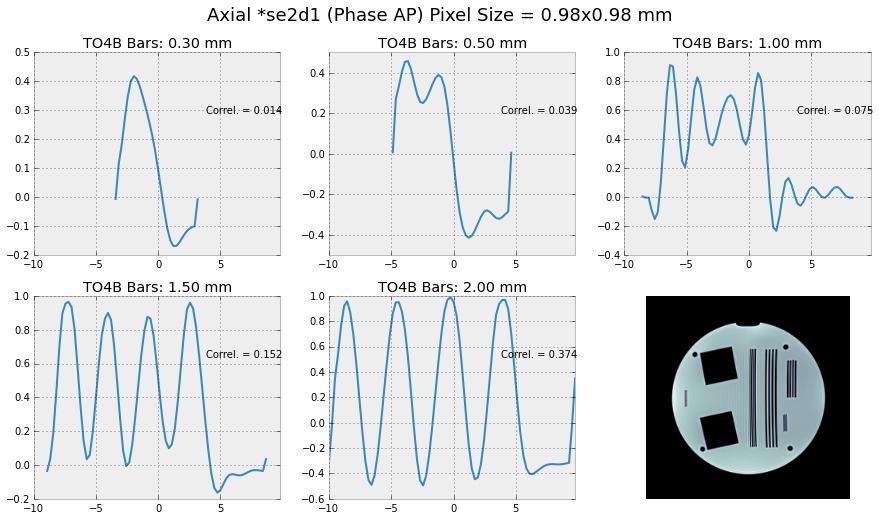

In [6]:
serno = seriesnos[1]
dobjs = fetch_series(patid, stuid, [serno])
images = [d.pixel_array & 0xfff for d in dobjs]
pix_dims = np.asarray(dobjs[0].PixelSpacing)
image = images[0]
if flipped_ud:
    image = np.flipud(image)
if flipped_rl:
    image = np.fliplr(image)
    
# find_phantom returns pixel coordinates in natural order (x, y)
expected_radius = phantom['Diameter'] / 2 / pix_dims[0]
centre_x, centre_y, radius = find_phantom(image, expected_radius=expected_radius)

fig = bar_report(image, pix_dims=pix_dims, centre=(centre_x, centre_y), phantom=phantom)
fig.suptitle("%s %s (Phase %s) Pixel Size = %0.2fx%0.2f mm" % (
                approx_slice_orientation(dobjs[0]),
                seq_name(dobjs[0]),
                approx_phase_orientation(dobjs[0]),
                pix_spacing_yx(dobjs[0])[1],
                pix_spacing_yx(dobjs[0])[0],
            ),
            fontsize=18
);

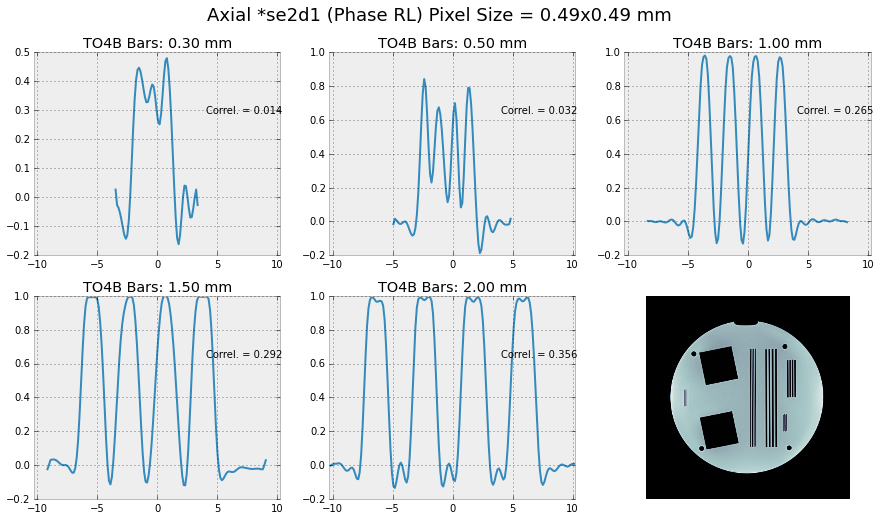

In [7]:
serno = seriesnos[2]
dobjs = fetch_series(patid, stuid, [serno])
images = [d.pixel_array & 0xfff for d in dobjs]
pix_dims = np.asarray(dobjs[0].PixelSpacing)
image = images[0]
if flipped_ud:
    image = np.flipud(image)
if flipped_rl:
    image = np.fliplr(image)
    
# find_phantom returns pixel coordinates in natural order (x, y)
expected_radius = phantom['Diameter'] / 2 / pix_dims[0]
centre_x, centre_y, radius = find_phantom(image, expected_radius=expected_radius)

fig = bar_report(image, pix_dims=pix_dims, centre=(centre_x, centre_y), phantom=phantom)
fig.suptitle("%s %s (Phase %s) Pixel Size = %0.2fx%0.2f mm" % (
                approx_slice_orientation(dobjs[0]),
                seq_name(dobjs[0]),
                approx_phase_orientation(dobjs[0]),
                pix_spacing_yx(dobjs[0])[1],
                pix_spacing_yx(dobjs[0])[0],
            ),
            fontsize=18
);

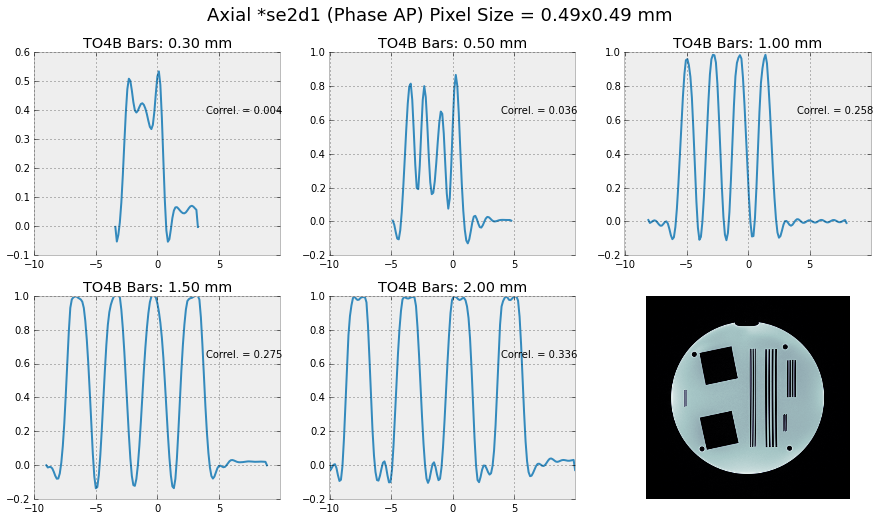

In [8]:
serno = seriesnos[3]
dobjs = fetch_series(patid, stuid, [serno])
images = [d.pixel_array & 0xfff for d in dobjs]
pix_dims = np.asarray(dobjs[0].PixelSpacing)
image = images[0]
if flipped_ud:
    image = np.flipud(image)
if flipped_rl:
    image = np.fliplr(image)
    
# find_phantom returns pixel coordinates in natural order (x, y)
expected_radius = phantom['Diameter'] / 2 / pix_dims[0]
centre_x, centre_y, radius = find_phantom(image, expected_radius=expected_radius)

fig = bar_report(image, pix_dims=pix_dims, centre=(centre_x, centre_y), phantom=phantom)
fig.suptitle("%s %s (Phase %s) Pixel Size = %0.2fx%0.2f mm" % (
                approx_slice_orientation(dobjs[0]),
                seq_name(dobjs[0]),
                approx_phase_orientation(dobjs[0]),
                pix_spacing_yx(dobjs[0])[1],
                pix_spacing_yx(dobjs[0])[0],
            ),
            fontsize=18
);

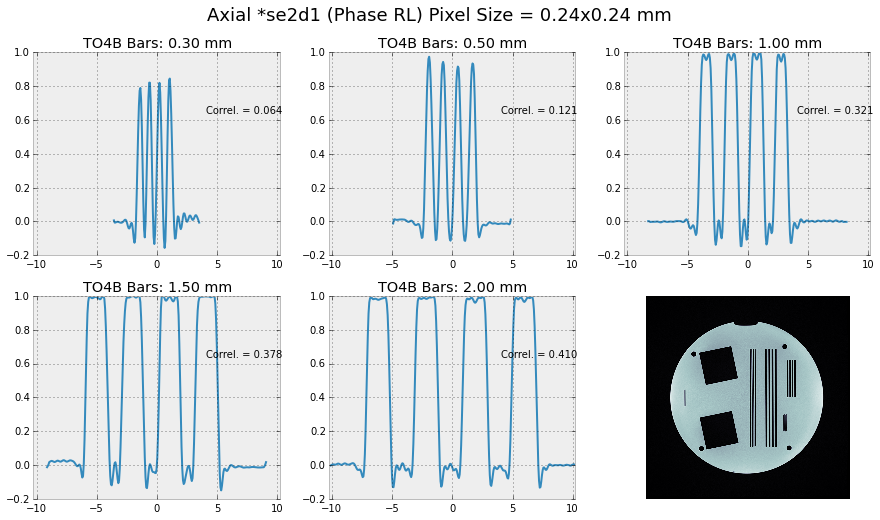

In [9]:
serno = seriesnos[4]
dobjs = fetch_series(patid, stuid, [serno])
images = [d.pixel_array & 0xfff for d in dobjs]
pix_dims = np.asarray(dobjs[0].PixelSpacing)
image = images[0]
if flipped_ud:
    image = np.flipud(image)
if flipped_rl:
    image = np.fliplr(image)
    
# find_phantom returns pixel coordinates in natural order (x, y)
expected_radius = phantom['Diameter'] / 2 / pix_dims[0]
centre_x, centre_y, radius = find_phantom(image, expected_radius=expected_radius)

fig = bar_report(image, pix_dims=pix_dims, centre=(centre_x, centre_y), phantom=phantom)
fig.suptitle("%s %s (Phase %s) Pixel Size = %0.2fx%0.2f mm" % (
                approx_slice_orientation(dobjs[0]),
                seq_name(dobjs[0]),
                approx_phase_orientation(dobjs[0]),
                pix_spacing_yx(dobjs[0])[1],
                pix_spacing_yx(dobjs[0])[0],
            ),
            fontsize=18
);

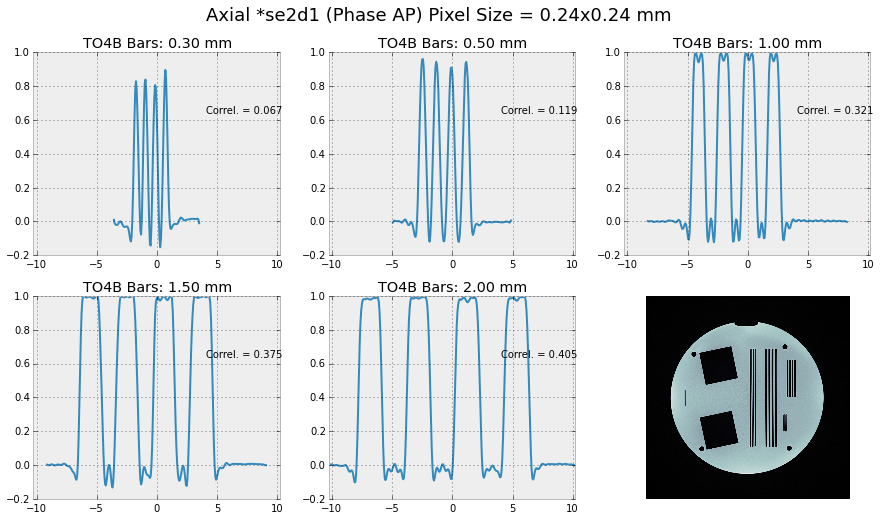

In [10]:
serno = seriesnos[5]
dobjs = fetch_series(patid, stuid, [serno])
images = [d.pixel_array & 0xfff for d in dobjs]
pix_dims = np.asarray(dobjs[0].PixelSpacing)
image = images[0]
if flipped_ud:
    image = np.flipud(image)
if flipped_rl:
    image = np.fliplr(image)
    
# find_phantom returns pixel coordinates in natural order (x, y)
expected_radius = phantom['Diameter'] / 2 / pix_dims[0]
centre_x, centre_y, radius = find_phantom(image, expected_radius=expected_radius)

fig = bar_report(image, pix_dims=pix_dims, centre=(centre_x, centre_y), phantom=phantom)
fig.suptitle("%s %s (Phase %s) Pixel Size = %0.2fx%0.2f mm" % (
                approx_slice_orientation(dobjs[0]),
                seq_name(dobjs[0]),
                approx_phase_orientation(dobjs[0]),
                pix_spacing_yx(dobjs[0])[1],
                pix_spacing_yx(dobjs[0])[0],
            ),
            fontsize=18
);

How do we assess this. We could take the cross correlation function and set a threshold on its maximum. 

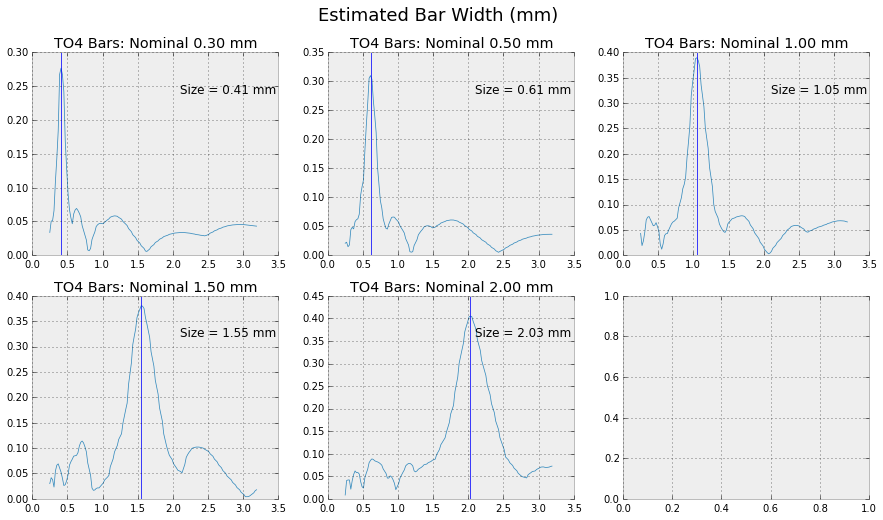

In [11]:
rects = phantom['Features']['Bars']
nbars = len(rects)

centre = (centre_x, centre_y)
zoom = 16
expected_spacings = phantom['FeatureSizes']['Bars']

rois = [bars_roi(image, pix_dims=pix_dims, rect=rects[i], centre=centre) for i in range(nbars)]
angles = [opt_angle(roi) for roi in rois]
angle = np.nanmean(angles[1:-1])

ncols = 3
nrows = int(np.ceil(len(rois)/float(ncols)))
posn_mins = []
posn_maxs = []

plt.rcParams['lines.linewidth'] = 0.75

fig, axs = subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 4*nrows))
for i, roi in enumerate(rois):
    profile = 1 - bar_profile(roi, angle=angle, zoom=zoom)
    posns = (np.arange(len(profile)) - len(profile)/2) * pix_dims[1] / zoom
    ax = axs.flat[i]
    bar_widths = np.arange(0.25, 3.2, 0.02)
    maxcorrs = np.asarray([
        correl_peak(profile, d_mm=np.mean(np.diff(posns)), bar_width_mm=bw)
        for bw in bar_widths
    ])
    ax.plot(bar_widths, maxcorrs)
    maxcorrs[bar_widths<0.5*expected_spacings[i]] = 0
    pk_index = np.argmax(maxcorrs)
    estimated_size = bar_widths[pk_index]
    ax.axvline(estimated_size)
    ax.text(0.6, 0.8, 'Size = %0.2f mm' % estimated_size, transform=ax.transAxes, fontsize=12)
    ax.set_title('TO4 Bars: Nominal %0.2f mm' % expected_spacings[i])
fig.suptitle('Estimated Bar Width (mm)', fontsize=18);